# Sequence-to-Sequence, seq2seq

SEOYEON CHOI  
2023-05-28

> Sequence-to-Sequence, seq2seq

Ref: [딥러닝을 이용한 자연어 처리 입문](https://wikidocs.net/24996),
[keras](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html)

# Seq2seq

*기본 디자인*

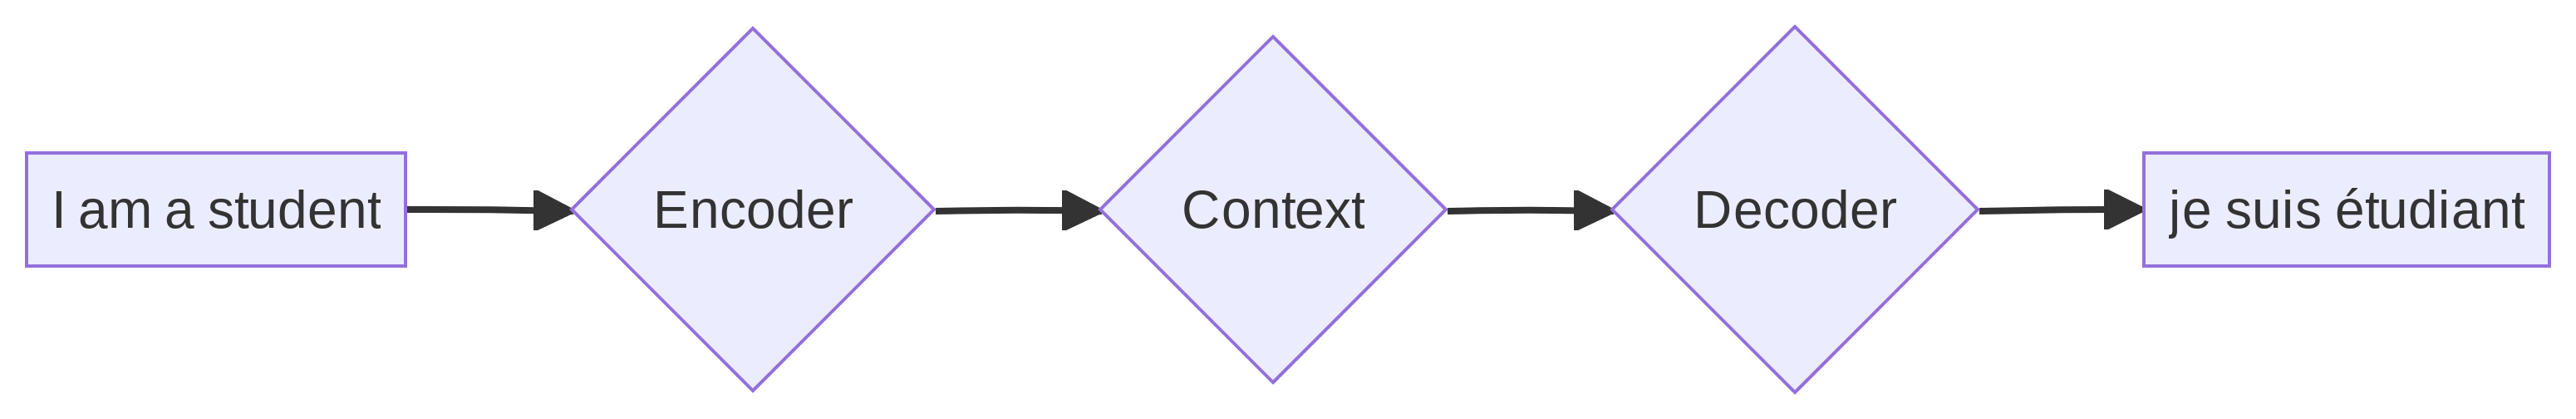

인코더

-   모든 단어들을 순차적으로 입력받은 뒤에 마지막에 이 모든 단어
    정보들을 압축해서 하나의 벡터로 만듦(컨텍스트 벡터)
-   이 컨텍스트 벡터[1]를 디코더로 전달

디코더

-   컨텍스트 벡터를 받아서 번역된 단어를 하나씩 순차적으로 출력

*내부 확대*

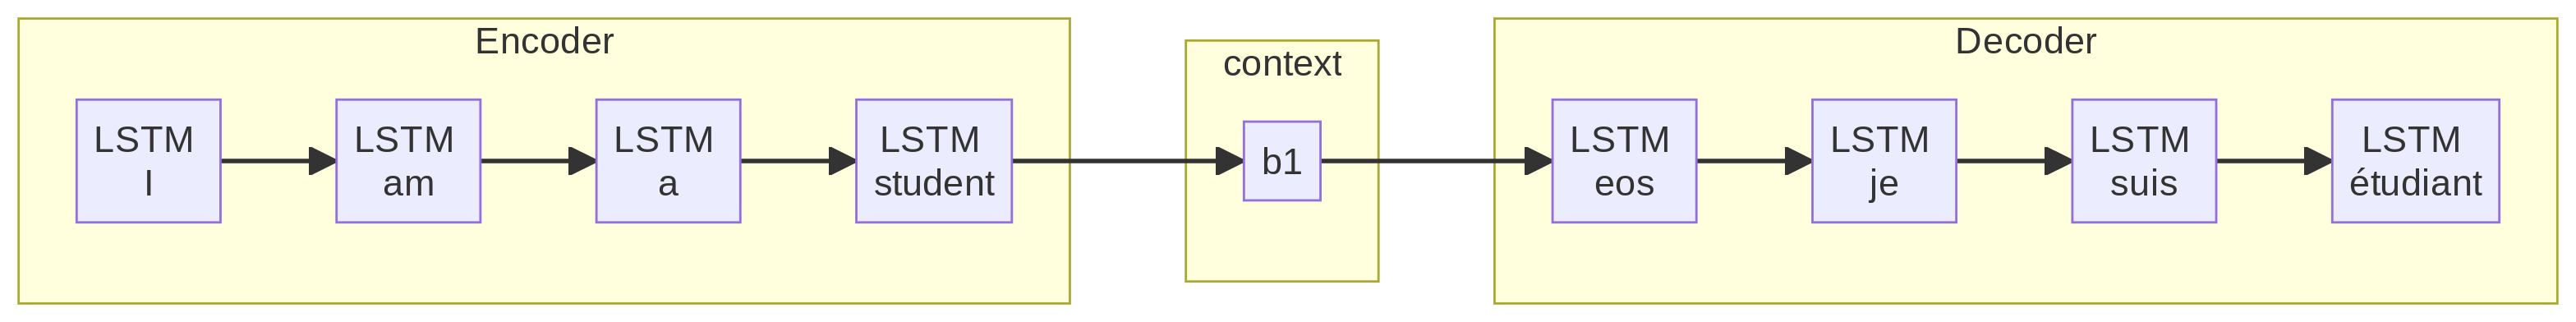

-   인코더와 디코더는 두 개의 RNN 아키텍처로 이루어져 있음.
-   인코더: 입력 문장을 받는 RNN 셀
-   디코더: 출력 문장을 받는 RNN 셀

**RNN, LSTM, GRU 중 무엇을 사용하느냐는 모델에 따라, 성능에 따라 달리
선택**

-   인코더는 단어 토큰화를 통해 단어들을 RNN 셀의 각 시점으로 입력하는데
    그 후에 인코더 RNN 셀의 마지막 시점의 은닉 상태(컨텍스트벡터)를
    디코더 RNN 셀로 넘겨줌.

**컨텍스트 벡터는 디코더의 첫번째 은닉 상태에 사용**

-   초기값인 sos가 들어가면 순차적으로 다음에 올 단어를 예측 후 다음
    타임스템에 전달, eos가 나올때까지 진행됨

> **Tip**
>
> $\star$ sos
>
> -   디코더의 초기 입력, 문장의 시작을 의미
> -   다음 등장할 확률이 높은 단어를 예측
>
> $\star$ eos
>
> -   디코더의 끝 값, 문장의 끝을 의미

-   각 RNNLM(RNN Language Model)은 단어 토큰을 입력 받을 때 임베딩
    과정을 거쳐서 텍스트를 벡터로 바꿈(단, 사이즈는 수백 개의 차원을
    가질 수 있음)

**하나의 RNN 셀 확대**

-   입력
    -   time step t-1에서의 은닉 상태
    -   현재 time-step t에서의 입력 벡터
-   은닉 상태(입력으로 만들어낸, 필요없으면 값 무시 가능)
    -   time step t에서의 은닉 상태
    -   현재 time-step t에서의 은닉 상태
-   의미하는 바
    -   현재 시점 t에서의 은닉 상태는 과거 시점의 동일한 RNN 셀에서의
        모든 은닉 상태의 값들의 영향을 누적해서 받아온 값
    -   입력 문장의 단어 토큰들의 정보를 요약해서 담고 있다고 할 수 있음

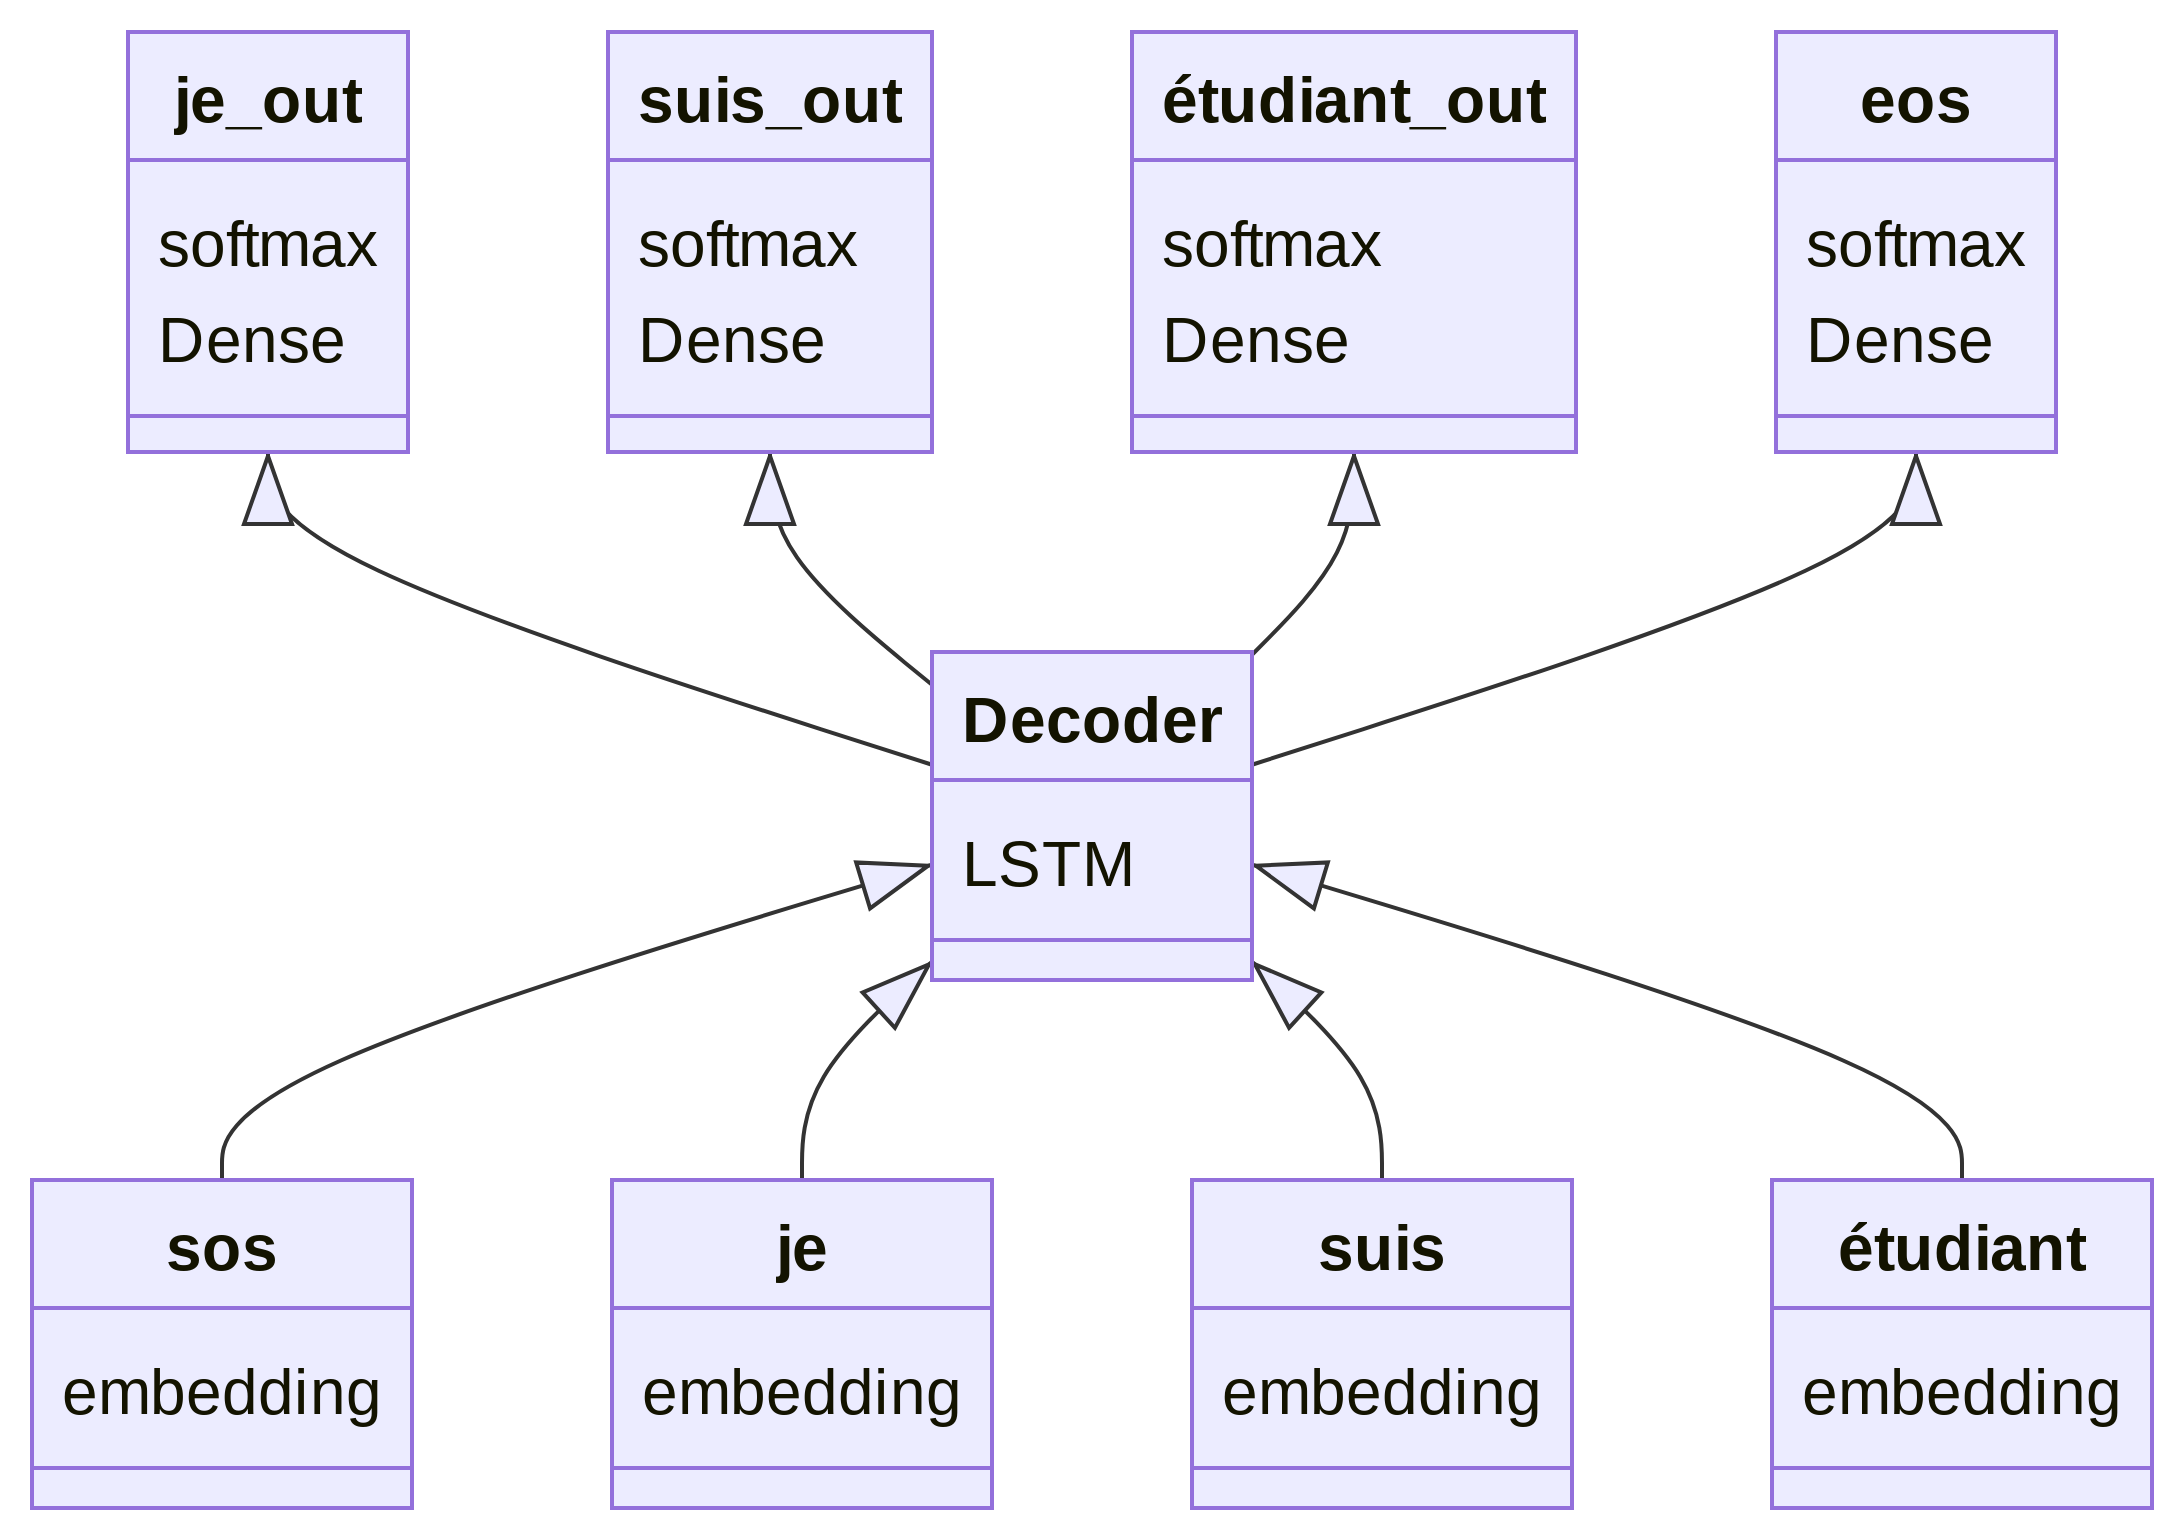

# 실습

[1] 컨텍스트 벡터는 보통 수백차원 이상

In [44]:
import os
import shutil
import zipfile

import pandas as pd
import tensorflow as tf
import urllib3
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [45]:
http = urllib3.PoolManager()
url ='http://www.manythings.org/anki/fra-eng.zip'
filename = 'fra-eng.zip'

In [47]:
path = os.getcwd()

In [49]:
path

'/home/csy/Dropbox/md/posts/ml_basic'

In [50]:
zipfilename = os.path.join(path, filename)

In [53]:
zipfilename

'/home/csy/Dropbox/md/posts/ml_basic/fra-eng.zip'

In [51]:
with http.request('GET', url, preload_content=False) as r, open(zipfilename, 'wb') as out_file:       
    shutil.copyfileobj(r, out_file)

with zipfile.ZipFile(zipfilename, ‘r’) as zip_ref:
zip_ref.extractall(path)

In [60]:
lines = pd.read_csv('./fra.txt', names=['src', 'tar', 'lic'], sep='\t')

In [61]:
del lines['lic']
print('전체 샘플의 개수 :',len(lines))

전체 샘플의 개수 : 217975

In [63]:
lines = lines.loc[:, 'src':'tar']
lines = lines[0:60000] # 6만개만 저장
lines.sample(10)

*sos, eos 대신 `\t`,`\n`를 입력*

In [64]:
lines.tar = lines.tar.apply(lambda x : '\t '+ x + ' \n')
lines.sample(10)

In [65]:
# 문자 집합 구축
src_vocab = set()
for line in lines.src: # 1줄씩 읽음
    for char in line: # 1개의 문자씩 읽음
        src_vocab.add(char)

tar_vocab = set()
for line in lines.tar:
    for char in line:
        tar_vocab.add(char)

In [66]:
src_vocab_size = len(src_vocab)+1
tar_vocab_size = len(tar_vocab)+1
print('source 문장의 char 집합 :',src_vocab_size)
print('target 문장의 char 집합 :',tar_vocab_size)

source 문장의 char 집합 : 80
target 문장의 char 집합 : 103

sorted 된 상태에서 인덱스 출력해야 함

In [67]:
src_vocab = sorted(list(src_vocab))
tar_vocab = sorted(list(tar_vocab))
print(src_vocab[45:75])
print(tar_vocab[45:75])

['W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
['T', 'U', 'V', 'W', 'X', 'Y', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x']

*문장에 인덱스 부여*

In [68]:
src_to_index = dict([(word, i+1) for i, word in enumerate(src_vocab)])
tar_to_index = dict([(word, i+1) for i, word in enumerate(tar_vocab)])
print(src_to_index)
print(tar_to_index)

{' ': 1, '!': 2, '"': 3, '$': 4, '%': 5, '&': 6, "'": 7, ',': 8, '-': 9, '.': 10, '/': 11, '0': 12, '1': 13, '2': 14, '3': 15, '4': 16, '5': 17, '6': 18, '7': 19, '8': 20, '9': 21, ':': 22, '?': 23, 'A': 24, 'B': 25, 'C': 26, 'D': 27, 'E': 28, 'F': 29, 'G': 30, 'H': 31, 'I': 32, 'J': 33, 'K': 34, 'L': 35, 'M': 36, 'N': 37, 'O': 38, 'P': 39, 'Q': 40, 'R': 41, 'S': 42, 'T': 43, 'U': 44, 'V': 45, 'W': 46, 'X': 47, 'Y': 48, 'Z': 49, 'a': 50, 'b': 51, 'c': 52, 'd': 53, 'e': 54, 'f': 55, 'g': 56, 'h': 57, 'i': 58, 'j': 59, 'k': 60, 'l': 61, 'm': 62, 'n': 63, 'o': 64, 'p': 65, 'q': 66, 'r': 67, 's': 68, 't': 69, 'u': 70, 'v': 71, 'w': 72, 'x': 73, 'y': 74, 'z': 75, '°': 76, 'é': 77, '’': 78, '€': 79}
{'\t': 1, '\n': 2, ' ': 3, '!': 4, '"': 5, '$': 6, '%': 7, '&': 8, "'": 9, '(': 10, ')': 11, ',': 12, '-': 13, '.': 14, '0': 15, '1': 16, '2': 17, '3': 18, '4': 19, '5': 20, '6': 21, '7': 22, '8': 23, '9': 24, ':': 25, '?': 26, 'A': 27, 'B': 28, 'C': 29, 'D': 30, 'E': 31, 'F': 32, 'G': 33, 'H': 3

train 데이터의 인코더에 정수 인코딩

In [70]:
encoder_input = []

# 1개의 문장
for line in lines.src:
    encoded_line = []
  # 각 줄에서 1개의 char
    for char in line:
    # 각 char을 정수로 변환
        encoded_line.append(src_to_index[char])
    encoder_input.append(encoded_line)
print('source 문장의 정수 인코딩 :',encoder_input[:5])

source 문장의 정수 인코딩 : [[30, 64, 10], [30, 64, 10], [30, 64, 10], [30, 64, 10], [31, 58, 10]]

디코더에 정수 인코딩

In [72]:
decoder_input = []
for line in lines.tar:
    encoded_line = []
    for char in line:
        encoded_line.append(tar_to_index[char])
    decoder_input.append(encoded_line)
print('target 문장의 정수 인코딩 :',decoder_input[:5])

target 문장의 정수 인코딩 : [[1, 3, 48, 52, 3, 4, 3, 2], [1, 3, 39, 52, 69, 54, 59, 56, 14, 3, 2], [1, 3, 31, 65, 3, 69, 66, 72, 71, 56, 3, 4, 3, 2], [1, 3, 28, 66, 72, 58, 56, 3, 4, 3, 2], [1, 3, 45, 52, 63, 72, 71, 3, 4, 3, 2]]

**디코더를 예측한 후 그 값과 비교하기 위한 실제 값을 위해 위에 추가한
`\t`를 없애주는 과정으로서 앞의 `1` 삭제**

In [74]:
decoder_target = []
for line in lines.tar:
    timestep = 0
    encoded_line = []
    for char in line:
        if timestep > 0:
            encoded_line.append(tar_to_index[char])
        timestep = timestep + 1
    decoder_target.append(encoded_line)
print('target 문장 레이블의 정수 인코딩 :',decoder_target[:5])

target 문장 레이블의 정수 인코딩 : [[3, 48, 52, 3, 4, 3, 2], [3, 39, 52, 69, 54, 59, 56, 14, 3, 2], [3, 31, 65, 3, 69, 66, 72, 71, 56, 3, 4, 3, 2], [3, 28, 66, 72, 58, 56, 3, 4, 3, 2], [3, 45, 52, 63, 72, 71, 3, 4, 3, 2]]

In [75]:
max_src_len = max([len(line) for line in lines.src])
max_tar_len = max([len(line) for line in lines.tar])
print('source 문장의 최대 길이 :',max_src_len)
print('target 문장의 최대 길이 :',max_tar_len)

source 문장의 최대 길이 : 22
target 문장의 최대 길이 : 76

영어 데이터끼리, 프랑스어 데이터끼리 길이를 맞추어 패딩 진행

In [77]:
encoder_input = pad_sequences(encoder_input, maxlen=max_src_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen=max_tar_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen=max_tar_len, padding='post')

원핫인코딩(문자 단위 번역기라 워드 임베딩은 별도로 사용하지 않음)

In [78]:
encoder_input = to_categorical(encoder_input)
decoder_input = to_categorical(decoder_input)
decoder_target = to_categorical(decoder_target)

## Teacher Forcing 교사 강요

-   train에서는 이전 시점의 디코더 셀의 출력을 현재 시점의 디코더 셀의
    입력으로 넣어주지 않음.
-   이전 시점의 실제값을 현재 시점의 디코더 셀의 입력값으로 하는 방법
    사용
    -   이전 시점의 디코더 셀의 예측이 틀렸는데 이를 현재 시점의 디코더
        셀의 입력으로 사용하면 현재 시점의 디코더 셀의 예측에도 잘못될
        가능성이 높음
    -   이는 연쇄 작용으로 디코더 전체의 예측을 어렵게 함
    -   이런 상황이 반복되면 훈련 시간이 느려질 수 있음

**교사 강요**

-   RNN의 모든 시점에 대해서 이전 시점의 예측값 대신 실제값을 입력으로
    주는 방법

## seq2seq 기계 번역기 훈련

In [81]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model
import numpy as np

`encoder_states` 가 바로 컨텍스트 벡터

In [82]:
encoder_inputs = Input(shape=(None, src_vocab_size))
encoder_lstm = LSTM(units=256, return_state=True)

# encoder_outputs은 여기서는 불필요
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

# LSTM은 바닐라 RNN과는 달리 상태가 두 개. 은닉 상태와 셀 상태.
encoder_states = [state_h, state_c]

``` python
return_state=True
```

인코더의 내부 상태를 디코더로 넘겨주기 위해, False면 리턴하지 않음

In [83]:
decoder_inputs = Input(shape=(None, tar_vocab_size))
decoder_lstm = LSTM(units=256, return_sequences=True, return_state=True)

# 디코더에게 인코더의 은닉 상태, 셀 상태를 전달.
decoder_outputs, _, _= decoder_lstm(decoder_inputs, initial_state=encoder_states)

decoder_softmax_layer = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="rmsprop", loss="categorical_crossentropy")

디코더는 은닉상태, 셀 상태를 사용하지 않기 때문에 `_`로 받아줌

In [84]:
model.fit(x=[encoder_input, decoder_input], y=decoder_target, batch_size=64, epochs=40, validation_split=0.2)

Epoch 1/40
750/750 [==============================] - 100s 131ms/step - loss: 0.8574 - val_loss: 0.7819
Epoch 2/40
750/750 [==============================] - 98s 131ms/step - loss: 0.5758 - val_loss: 0.6667
Epoch 3/40
750/750 [==============================] - 144s 191ms/step - loss: 0.5051 - val_loss: 0.6056
Epoch 4/40
750/750 [==============================] - 171s 229ms/step - loss: 0.4589 - val_loss: 0.5569
Epoch 5/40
750/750 [==============================] - 159s 213ms/step - loss: 0.4232 - val_loss: 0.5200
Epoch 6/40
750/750 [==============================] - 154s 205ms/step - loss: 0.3958 - val_loss: 0.4920
Epoch 7/40
750/750 [==============================] - 109s 145ms/step - loss: 0.3745 - val_loss: 0.4701
Epoch 8/40
750/750 [==============================] - 105s 140ms/step - loss: 0.3572 - val_loss: 0.4552
Epoch 9/40
750/750 [==============================] - 119s 159ms/step - loss: 0.3429 - val_loss: 0.4391
Epoch 10/40
750/750 [==============================] - 163s 218ms

## seq2seq 기계 번역기 동작

STEP 1. 번역하고자 하는 입력 문장이 인코더에 들어가 은닉 상태와 셀
상태를 얻는다.

STEP 2. 상태와 `<sos>`에 해당하는 `\t` 를 디코더로 보낸다.

STEP 3. elzhejrk `<eos>`에 해당하는 `\n`이 나올 때까지 다음 문자를
예측하는 행동을 반복한다.

In [87]:
encoder_model = Model(inputs=encoder_inputs, outputs=encoder_states)

인코더 정의

In [157]:
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용.
# 뒤의 함수 decode_sequence()에 동작을 구현 예정
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)

# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태를 버리지 않음.
decoder_states = [state_h, state_c]
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs] + decoder_states)

In [158]:
decoder_inputs

<KerasTensor: shape=(None, None, 103) dtype=float32 (created by layer 'input_2')>

In [159]:
decoder_states_inputs

[<KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'input_5')>,
 <KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'input_6')>]

디코더 설계

In [89]:
index_to_src = dict((i, char) for char, i in src_to_index.items())
index_to_tar = dict((i, char) for char, i in tar_to_index.items())

인덱스에서 단어를 얻을 수 있도록 `index_to_~`설계

In [109]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1, 1, tar_vocab_size))
    target_seq[0, 0, tar_to_index['\t']] = 1.

    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

    # 예측 결과를 문자로 변환
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = index_to_tar[sampled_token_index]

    # 현재 시점의 예측 문자를 예측 문장에 추가
    decoded_sentence += sampled_char

    # <eos>에 도달하거나 최대 길이를 넘으면 중단.
    if (sampled_char == '\n' or
        len(decoded_sentence) > max_tar_len):
        stop_condition = True

    # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
    target_seq = np.zeros((1, 1, tar_vocab_size))
    target_seq[0, 0, sampled_token_index] = 1.

    # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
    states_value = [h, c]

    return decoded_sentence

#### step by step

In [166]:
input_seq = encoder_input[5:10]

In [167]:
states_value = encoder_model.predict(input_seq)

1/1 [==============================] - 0s 31ms/step

In [168]:
# <SOS>에 해당하는 원-핫 벡터 생성
target_seq = np.zeros((1, 1, tar_vocab_size))

In [169]:
target_seq

array([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.]]])

In [170]:
target_seq[0, 0, tar_to_index['\t']] = 1.

In [171]:
target_seq

array([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.]]])

In [172]:
stop_condition = False

In [173]:
decoded_sentence = ""

In [188]:
# Check dimensions of input arrays
print(target_seq.shape)            # Shape of target_seq
print(states_value[0].shape)       # Shape of states_value[0]
print(states_value[1].shape)       # Shape of states_value[1]
print(states_value[0][1,:].reshape(1,-1).shape)
print(states_value[1][1,:].reshape(1,-1).shape)

(1, 1, 103)
(5, 256)
(5, 256)
(1, 256)
(1, 256)

In [194]:
states_value_tmp = [states_value[0][1,:].reshape(1,-1), states_value[1][1,:].reshape(1,-1)]

In [ ]:
# stop_condition이 True가 될 때까지 루프 반복
while not stop_condition:
    # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
    output_tokens, h, c = decoder_model.predict([target_seq] + states_value_tmp)

In [ ]:
output_tokens, h, c = decoder_model.predict([target_seq] + states_value_tmp)

In [ ]:
# 예측 결과를 문자로 변환
sampled_token_index = np.argmax(output_tokens[0, -1, :])
sampled_token_index

In [ ]:
sampled_char = index_to_tar[sampled_token_index]
sampled_char

In [ ]:
# 현재 시점의 예측 문자를 예측 문장에 추가
decoded_sentence += sampled_char

In [ ]:
# <eos>에 도달하거나 최대 길이를 넘으면 중단.
if (sampled_char == '\n' or
    len(decoded_sentence) > max_tar_len):
    stop_condition = True

In [ ]:
# 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
target_seq = np.zeros((1, 1, tar_vocab_size))
target_seq

In [ ]:
target_seq[0, 0, sampled_token_index] = 1.

In [ ]:
# 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
states_value = [h, c]

In [ ]:
print('입력 문장:', lines.src[5])
print('정답 문장:', lines.tar[5][2:len(lines.tar[5])-1]) # '\t'와 '\n'을 빼고 출력
print('번역 문장:', decoded_sentence[1:len(decoded_sentence)-1]) # '\n'을 빼고 출력

In [ ]:
for seq_index in [3,4]: # 입력 문장의 인덱스
    input_seq = encoder_input[seq_index:seq_index+1]
    decoded_sentence = decode_sequence(input_seq)
    # print(35 * "-")
    print('입력 문장:', lines.src[seq_index])
    print('정답 문장:', lines.tar[seq_index][2:len(lines.tar[seq_index])-1]) # '\t'와 '\n'을 빼고 출력
    print('번역 문장:', decoded_sentence[1:len(decoded_sentence)-1]) # '\n'을 빼고 출력